# MALCOM Lab Session 1

# Neural Network Implementation and Training
In this lab session, we will develop a simple neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
# Setup

import numpy as np
import matplotlib.pyplot as plt

from neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We will use the class `TwoLayerNet` in the file `malcom/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. We will start with initializing toy data and a toy model, which we will use to further develop the neural network implementation.

In [2]:
# We create a small network and some toy data to check our implementations.
# Random seed is set for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `malcom/neural_net.py` and look at the method `TwoLayerNet.loss`. This function takes the data and weights and computes the class scores, the loss, and the gradients on the parameters. 

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('Correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small, less than 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and the regularization loss.

In [4]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# This should be very small, less than 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7985612998927536e-13


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. To check that the forward pass has been implemented correctly, you can debug your backward pass using a numeric gradient check:

In [5]:
from gradient_check import eval_numerical_gradient


loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447625e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 2.738421e-09


# Neural Network Training
To train the neural network, we will use stochastic gradient descent (SGD). Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. 

You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you have implemented the method, run the code below to train a two-layer network on some toy data. The expected training loss should be less than 0.02.

Final training loss:  0.0018967913078311545


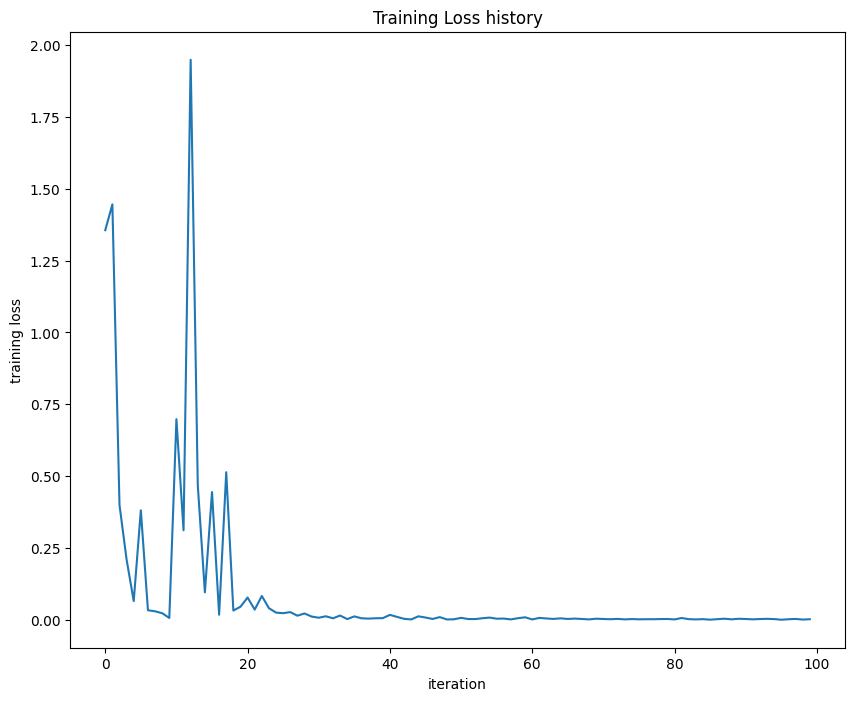

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6, batch_size=3,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# CIFAR-10 Data Loading
We will now train the implemented neural network in a real dataset, the widely used CIFAR-10.
You can download this dataset at: https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Then, you can put it in the folder malcom/datasets (or anywhere else you want, but then you will need to change the path in the below code).

In [7]:
from datasets.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    This will allows us to load the CIFAR-10 dataset and perform preprocessing to prepare
    it for the two-layer neural net classifier.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Network Training
To train our network we will use (as before) SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [8]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302758
iteration 100 / 1000: loss 2.302203
iteration 200 / 1000: loss 2.297143
iteration 300 / 1000: loss 2.261029
iteration 400 / 1000: loss 2.192505
iteration 500 / 1000: loss 2.135792
iteration 600 / 1000: loss 2.109815
iteration 700 / 1000: loss 2.035331
iteration 800 / 1000: loss 1.972633
iteration 900 / 1000: loss 1.914096
Validation accuracy:  0.279


# Training Debugging
With the default parameters set above, the validation accuracy should be around 0.29 on the validation set. This is a relatively poor performance.

One strategy to understand where is the problem is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. 

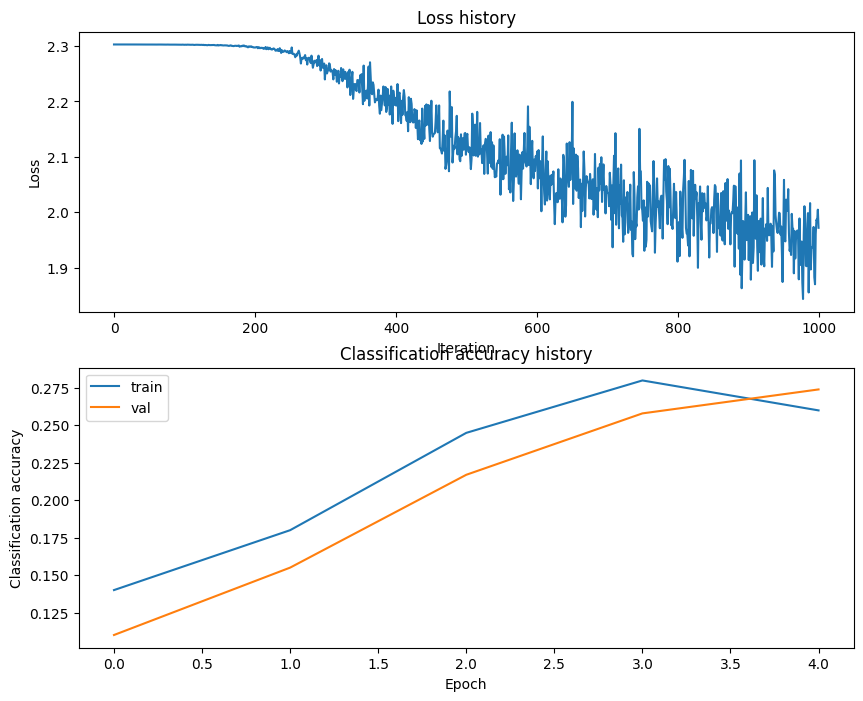

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

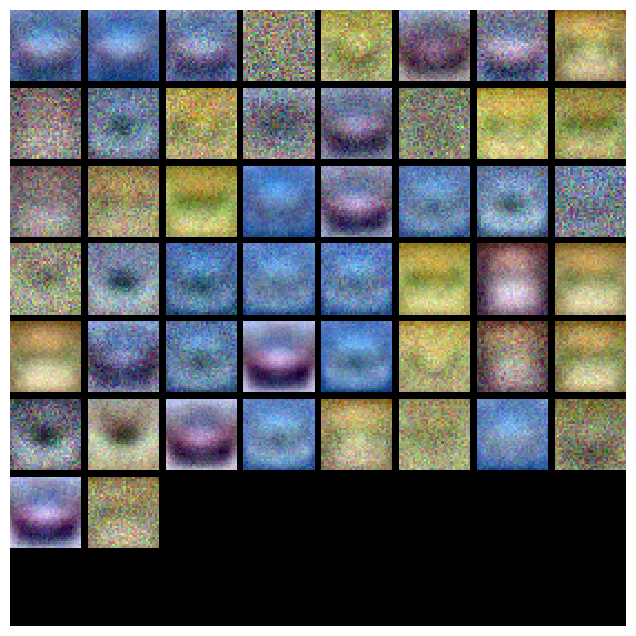

In [10]:
from vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Hyperparameters tuning

**What's wrong?**. Looking at the visualizations above, we observe that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how these hyperparameters affect the final performance is an important task in Neural Networks - one would need a lot of practice and experience to get this skill. 
Here, we will experiment with different values of the various hyperparameters, including hidden layer size, learning rate, number of training epochs, and regularization strength. 
You might also consider tuning the learning rate decay (but even without this, you should be able to get good performance).

**Target accuracy**. The target classification accuracy to be achieved should be greater than 48% on the validation set. 

**Experiment**: The goal here is to get the best result possible on CIFAR-10. The best performance, with a more elaborated network, should be around 52%. 
Students with prior ML background could also implement various techniques to improve performance (e.g. PCA to reduce dimensionality, dropout, adding features to the solver, etc.). This is not needed though for getting good performance, unless we want to really approach the reference accuracy value.

**Explain your hyperparameter tuning process below.**

$\color{blue}{\textit {Your Answer}}$ TO BE COMPLETED 


To tune the hyperparameters in order to achieve a greater accuracy on the validation set, I experimented with various hyperparameters changing their values. I tried different values for learning rate, hidden layers, regularization strength, and number of iterations.

At first I implemented a grid search to systematically see the various different combinations and take the one that gave best results, based on accuracy values.

I noticed that with a learning rate too high (e.g. 1e-2) the updates to the weights during training are so large that caused the loss to become NaN (exploding gradient phenomena), thus I used smaller learning rates. To avoid computation cost increase and time consuming, I added a check in the neural net from line 204 to stop the training for that particular learning rate if loss was NaN for 3 consecutive iterations.
Regarding the hidden size, larger ones make the model more complex and with increased capacity, but it could cause overfitting and increase the computational cost, I tried with 150 and 200.

For regularization strength, which controls the amount of regularization applied to the weigths of the network, I tried some values between 0.15 and 0.3.


The results obtained are:
- learning rate: 0.001
- hidden_size: 200
- reg_strength: 0.15

I used num_iters = 3000 to train my network with the best parameters.

The accuracy obtained on the test set is 54.2%, while on the validation 54.1%.


I also implemented PCA for dimensionality reduction, obtaining an accuracy on the test set of 52.1%, and a training accuracy a bit lower than the one obtained without PCA, which states that helps to not get overfitting.

iteration 0 / 2500: loss 2.302950


/Users/sararosato/Desktop/GitHub/malcom/Lab1/neural_net.py:110: RuntimeWarning: divide by zero encountered in log
  correct_log_probs = -np.log(prob[np.arange(N), y])


iteration 100 / 2500: loss inf
iteration 200 / 2500: loss inf
iteration 300 / 2500: loss inf


/Users/sararosato/Desktop/GitHub/malcom/Lab1/neural_net.py:107: RuntimeWarning: overflow encountered in subtract
  exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True)) # for numerical stability
/Users/sararosato/Desktop/GitHub/malcom/Lab1/neural_net.py:107: RuntimeWarning: invalid value encountered in subtract
  exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True)) # for numerical stability


Loss is NaN for the last few iterations. Stopping training with this learning rate.
Validation accuracy:  0.087
iteration 0 / 2500: loss 2.303027
iteration 100 / 2500: loss inf
iteration 200 / 2500: loss inf
iteration 300 / 2500: loss inf
Loss is NaN for the last few iterations. Stopping training with this learning rate.
Validation accuracy:  0.087
iteration 0 / 2500: loss 2.303165
iteration 100 / 2500: loss inf
iteration 200 / 2500: loss inf
iteration 300 / 2500: loss inf
Loss is NaN for the last few iterations. Stopping training with this learning rate.
Validation accuracy:  0.087
iteration 0 / 2500: loss 2.303021
iteration 100 / 2500: loss inf
iteration 200 / 2500: loss inf
iteration 300 / 2500: loss inf
Loss is NaN for the last few iterations. Stopping training with this learning rate.
Validation accuracy:  0.087
iteration 0 / 2500: loss 2.303242
iteration 100 / 2500: loss inf
iteration 200 / 2500: loss inf
iteration 300 / 2500: loss inf
Loss is NaN for the last few iterations. Sto

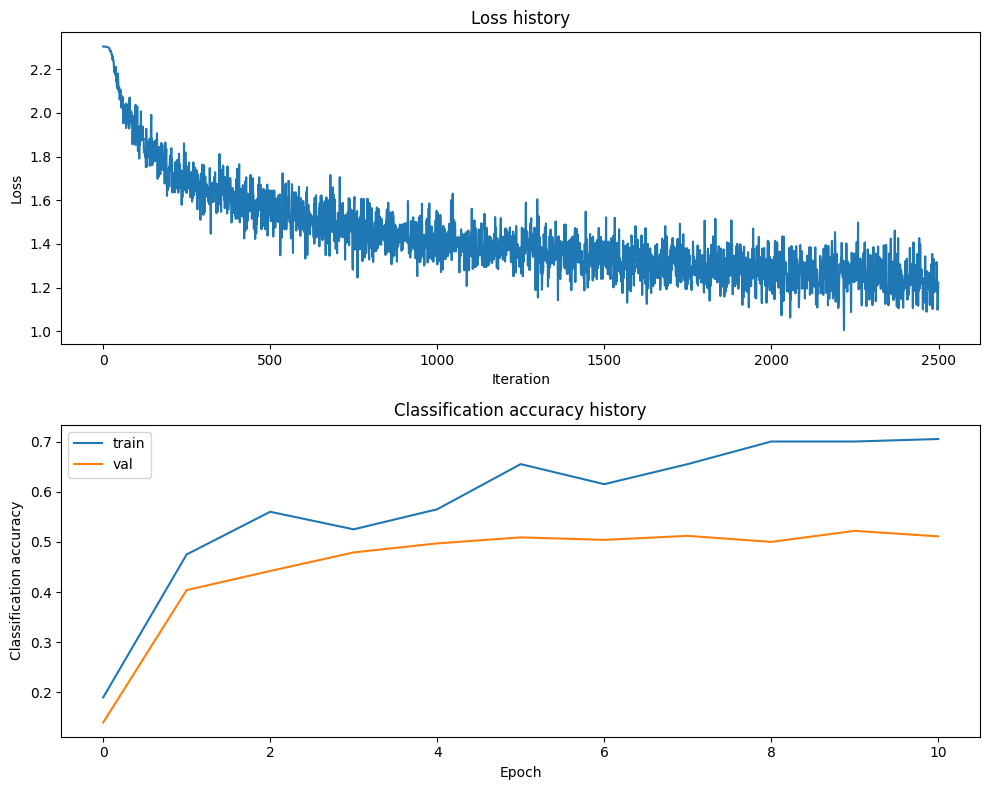

In [11]:
import numpy as np
#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
#################################################################################
# *****START OF YOUR CODE*****
input_size = 32 * 32 * 3
# hidden_size = 200 # increased number of neurons to increase the capacity of the network
# num_classes = 10
# best_net = TwoLayerNet(input_size, hidden_size, num_classes)

# # Train the network
# stats = best_net.train(X_train, y_train, X_val, y_val,
#             num_iters=3000, batch_size=200,
#             learning_rate=1e-3, learning_rate_decay=0.95,
#             reg=0.25, verbose=True)

# # Predict on the validation set
# val_acc = (best_net.predict(X_val) == y_val).mean()
# print('Validation accuracy: ', val_acc)

# *** START OF MY CODE ***
# grid search approach to find the best hyperparameters
learning_rates = [1e-2, 1e-3, 1e-4]
hidden_sizes = [150, 200]
regularization_strengths = np.arange(0.15, 0.3, 0.05)

num_iterations = [2000, 2500, 3000]

best_val_acc = -1
best_hyperparams = {}
best_stats = None

# Iterate over all possible combinations of hyperparameters
for lr in learning_rates:
    for hidden_size in hidden_sizes:
        for reg_strength in regularization_strengths:
            net = TwoLayerNet(input_size, hidden_size, num_classes)
            stats = net.train(X_train, y_train, X_val, y_val,
                                        num_iters=2500, batch_size=200,
                                        learning_rate=lr, learning_rate_decay=0.95,
                                        reg=reg_strength, verbose=True)
            val_acc = (net.predict(X_val) == y_val).mean()
            print('Validation accuracy: ', val_acc)
            # Store the best hyperparameters
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_hyperparams = {
                    'learning_rate': lr,
                    'hidden_size': hidden_size,
                    'reg_strength': reg_strength,
                }
                best_net_param = net
                best_stats = stats

# Train the model using the best hyperparameters

stats = best_net_param.train(X_train, y_train, X_val, y_val,
                                num_iters=3000, batch_size=200,
                                learning_rate=best_hyperparams['learning_rate'], learning_rate_decay=0.95,
                                reg=best_hyperparams['reg_strength'], verbose=True)
# compute the validation accuracy 
val_acc = (best_net_param.predict(X_val) == y_val).mean()

print('Best hyperparameters:', best_hyperparams)


# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# *****END OF YOUR CODE*****

In [12]:
print(f'Validation accuracy: {best_val_acc}')

Validation accuracy: 0.541


In [13]:
# %pip install scikit-learn
from sklearn.decomposition import PCA

# Perform PCA for dimensionality reduction
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Create a new instance of the neural network with PCA-transformed data
best_net_pca = TwoLayerNet(X_train_pca.shape[1], best_hyperparams['hidden_size'], num_classes)

# Train the network with PCA-transformed data
stats_pca = best_net_pca.train(X_train_pca, y_train, X_val_pca, y_val,
                               num_iters=3000, batch_size=200, learning_rate=best_hyperparams['learning_rate'], learning_rate_decay=0.95,
                               reg=best_hyperparams['reg_strength'], verbose=True)

# Evaluate the network with PCA-transformed data
val_acc_pca = (best_net_pca.predict(X_val_pca) == y_val).mean()
print('Validation accuracy with PCA: ', val_acc_pca)

iteration 0 / 3000: loss 2.302605
iteration 100 / 3000: loss 1.833827
iteration 200 / 3000: loss 1.913802
iteration 300 / 3000: loss 1.595967
iteration 400 / 3000: loss 1.657826
iteration 500 / 3000: loss 1.561754
iteration 600 / 3000: loss 1.413047
iteration 700 / 3000: loss 1.469510
iteration 800 / 3000: loss 1.408592
iteration 900 / 3000: loss 1.479146
iteration 1000 / 3000: loss 1.397664
iteration 1100 / 3000: loss 1.550268
iteration 1200 / 3000: loss 1.428677
iteration 1300 / 3000: loss 1.354442
iteration 1400 / 3000: loss 1.478230
iteration 1500 / 3000: loss 1.442002
iteration 1600 / 3000: loss 1.358548
iteration 1700 / 3000: loss 1.346060
iteration 1800 / 3000: loss 1.371570
iteration 1900 / 3000: loss 1.331802
iteration 2000 / 3000: loss 1.329003
iteration 2100 / 3000: loss 1.238942
iteration 2200 / 3000: loss 1.489222
iteration 2300 / 3000: loss 1.324085
iteration 2400 / 3000: loss 1.365726
iteration 2500 / 3000: loss 1.323252
iteration 2600 / 3000: loss 1.348637
iteration 270

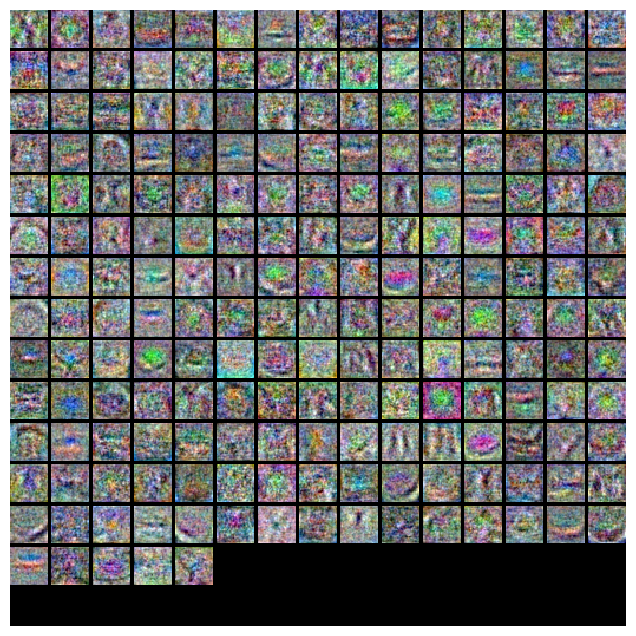

In [14]:
# visualize the weights of the best network
show_net_weights(best_net_param)

# Run on the test set
When you are done experimenting, you should evaluate your final trained neural network on the test set. We expect to get accuracy above 48%.

In [15]:
test_acc = (best_net_param.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

test_acc_pca = (best_net_pca.predict(X_test_pca) == y_test).mean()
print('Test accuracy PCA: ', test_acc_pca)


Test accuracy:  0.542
Test accuracy PCA:  0.521


In [16]:
train_acc = (best_net_param.predict(X_train) == y_train).mean()
print('Training accuracy: ', train_acc)

train_acc_pca = (best_net_pca.predict(X_train_pca) == y_train).mean()
print('Training accuracy PCA: ', train_acc_pca)

Training accuracy:  0.6944081632653061
Training accuracy PCA:  0.5616530612244898


**Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. Which of the below (possibly multiple) ways can decrease this gap?

1. Increase the regularization strength.
2. Train on a larger dataset.
3. Add more hidden units.
4. None of the above.

$\color{blue}{\textit{Your Answer - Please Explain}}$ 

The gap between training and testing accuracy could be a indication of the overfitting, since the model performs well on the training data but poorly on new unseen data (testing dataset). The first two options are the most useful to decrease the gap:
1. Increasing the regularization strength adds a penalty to the loss function based on the size of the weights, going towards a simpler model which might generalize better.
2. Train on a larger dataset can help reduce overfitting, because the model can learn the underlying patterns and generalize better on new data.

On the other side, instead, adding more hidden units makes the model more complex, possibly leading to more overfitting, thus this is not a good option.